In this file, we detect the switching pts without rank deduction. 

Here I do CPD such that both U and V are orthornormal

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

%matplotlib inline

In [11]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [6]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_eigvals, update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG

import gtvdn.gtvdn_utils
importlib.reload(gtvdn.gtvdn_utils)
from gtvdn.gtvdn_utils import get_bspline_est , get_newdata 

In [8]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.tensor
importlib.reload(utils.tensor)
from utils.tensor import decompose_three_way_orth, decompose_three_way_fix, sort_orthCPD

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Set parameters

In [9]:
# in case you want to update any parameters
paras.keys()

dict_keys(['is_detrend', 'decimate_rate', 'T', 'lamb', 'fct', 'downsample_rate', 'r', 'Lmin', 'maxM', 'kappa', 'wh', 'kps', 'L', 'num_ranks', 'cutoff', 'Cs', 'penalty', 'data_dir', 'res_dir', 'fig_dir', 'cur_dir'])

## Load data

In [12]:
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [13]:
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [14]:
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]

In [15]:
import mat73
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

In [16]:
baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [17]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [23]:
print(np.median(np.abs(ADDatsAll)), np.median(np.abs(CtrlDatsAll)))
print(np.mean(np.abs(ADDatsAll)), np.mean(np.abs(CtrlDatsAll)))

276.9328 1964.9369
2392.0566 10322.05


1964.9369

## Validate the function (No need, correct)

In [10]:
from tqdm import trange
from scipy.stats import multivariate_normal as mnorm


# Function to obtain the sum of Ai matrix
def GetAmatMul(dXmats, Xmats, timeSpan, downrate=1, fct=1):
    """
    Input: 
        dXmats: The first derivative of Xmats, N x d x n matrix
        Xmats: Xmat, N x d x n matrix
        timeSpan: A list of time points with length n
        downrate: The downrate factor, determine how many Ai matrix to be summed
    Return:
        A d x d matrix, it is sum of N x n/downrate  Ai matrix
    """
    h = pybwnrd0(timeSpan)*fct
    N, d, n = Xmats.shape
    Amats = []
    for ix in trange(N):
        Amat = np.zeros((d, d))
        Xmat, dXmat = Xmats[ix, :, :], dXmats[ix, :, :]
        curAmat = np.zeros((d, d))
        for s in timeSpan[::downrate]:
            t_diff = timeSpan - s
            kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
            kernelroot = kernels ** (1/2)
            kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
            kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
            M = kerXmat.T.dot(kerXmat)/n
            XY = kerdXmat.T.dot(kerXmat)/n # it is Y\trans x X , formula is Amat = Y\trans X (X\trans X)^{-1}
            U, S, VT = np.linalg.svd(M)
            # Num of singular values to keep
            r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
            invM = VT.T[:, :r].dot(np.diag(1/S[:r])).dot(U.T[:r, :]) # M is symmetric and PSD
            curAmat = curAmat + XY.dot(invM)
            Amat = Amat + curAmat
        Amats.append(Amat)
    return Amats

def GetNewDataMul(dXmats, Xmats, Amats, rRaw, is_full=False):
    """
    Input: 
        dXmats: The first derivative of Xmats, N x d x n matrix
        Xmats: Xmat, N x d x n matrix
        Amat: The A matrix to to eigendecomposition, d x d
        rRaw:    The rank of A matrix
              If r is decimal, the rank is the number of eigen values which account for 100r % of the total variance
              If r is integer, the r in algorithm can be r + 1 if r breaks the conjugate eigval pairs. 
        is_full: Where return full outputs or not
    Return: 
        nXmats, ndXmats, N x r x n 
    """
    N = len(Amats)
    fullRess = []
    for ix in trange(N):
        r = rRaw
        Amat = Amats[ix]
        Xmat, dXmat = Xmats[ix],  dXmats[ix]
        
        eigVals, eigVecs = np.linalg.eig(Amat)
        # sort the eigvs and eigvecs
        sidx = np.argsort(-np.abs(eigVals))
        eigVals = eigVals[sidx]
        eigVecs = eigVecs[:, sidx]
        if r is None:
            rSel = np.where(np.cumsum(np.abs(eigVals))/np.sum(np.abs(eigVals)) >0.8)[0][0] + 1
            r = rSel
        elif r < 1:
            rSel = np.where(np.cumsum(np.abs(eigVals))/np.sum(np.abs(eigVals)) >r)[0][0] + 1
            r = rSel
            
        # if breaking conjugate eigval pair, add r with 1
        if (eigVals[r-1].imag + eigVals[r].imag ) == 0:
            r = r + 1
    
        eigValsfull = np.concatenate([[np.Inf], eigVals])
        kpidxs = np.where(np.diff(np.abs(eigValsfull))[:r] != 0)[0]
        eigVecsInv = np.linalg.inv(eigVecs)
        
        tXmat =  np.matmul(eigVecsInv[kpidxs, :], Xmat)
        tdXmat =  np.matmul(eigVecsInv[kpidxs, :], dXmat)
        nrow, n = tXmat.shape
        nXmat = np.zeros((r, n))
        ndXmat = np.zeros((r, n))
        # Now I change to real first, then imag
        # Note that for real eigval, we do not need imag part.
        nXmat[:nrow, :] = tXmat.real
        nXmat[nrow:, :] =  tXmat.imag[(np.abs(eigVals.imag)!=0)[kpidxs], :]
        ndXmat[:nrow, :] = tdXmat.real
        ndXmat[nrow:, :] =  tdXmat.imag[(np.abs(eigVals.imag)!=0)[kpidxs], :]
        fullRes = edict({"ndXmat":ndXmat, "nXmat":nXmat, "kpidxs":kpidxs, "eigVecs":eigVecs, "eigVals":eigVals, "r": r})
        fullRess.append(fullRes)
    return fullRess
def ScreeningMul(Ress, wh=10, showProgress=True):
    """
    Input:
        wh: screening window size
    """
    # Get the scanning stats at index k
    def GetScanStats(k, wh):
        lidx = k - wh + 1
        uidx = k + wh + 1

        pndXmatA = ndXmat[:, lidx:uidx]
        pnXmatA = nXmat[:, lidx:uidx]
        GamkA = GetGammak(pndXmatA, pnXmatA)
        nlogA = GetNlogk(pndXmatA, pnXmatA, GamkA)

        pndXmatL = ndXmat[:, lidx:(k+1)]
        pnXmatL = nXmat[:, lidx:(k+1)]
        GamkL = GetGammak(pndXmatL, pnXmatL)
        nlogL = GetNlogk(pndXmatL, pnXmatL, GamkL)

        pndXmatR = ndXmat[:, (k+1):uidx]
        pnXmatR = nXmat[:, (k+1):uidx]
        GamkR = GetGammak(pndXmatR, pnXmatR)
        nlogR = GetNlogk(pndXmatR, pnXmatR, GamkR)

        return nlogR + nlogL - nlogA

    N = len(Ress)
    _, n = Ress[0].ndXmat.shape
    canptss = []
    if showProgress:
        iterBar = trange(N, desc="Screening")
    else:
        iterBar = range(N)
    for ix in iterBar:
        ndXmat, nXmat = Ress[ix].ndXmat, Ress[ix].nXmat
        scanStats = []
        for iy in range(n):
            if iy < (wh-1):
                scanStats.append(np.inf)
            elif iy >= (n-wh):
                scanStats.append(np.inf)
            else:
                scanStats.append(GetScanStats(iy, wh))

        canpts = []
        for idx, scanStat in enumerate(scanStats):
            if (idx >= (wh-1)) and (idx < (n-wh)):
                lidx = idx - wh + 1
                uidx = idx + wh + 1
                if scanStat == np.min(scanStats[lidx:uidx]):
                    canpts.append(idx) # the change point is from 0 not 1

        canptss.append(canpts)
    return canptss

In [20]:
YmatCtrl = prepMEG(CtrlDatsAll[:], paras)
YmatAD = prepMEG(ADDatsAll[:], paras)

In [21]:
timeSpan = np.linspace(0, paras.T, YmatAD.shape[-1])

dXmatsAD, XmatsAD = GetBsplineEst(YmatAD, timeSpan, paras.lamb)
dXmatsCtrl, XmatsCtrl = GetBsplineEst(YmatCtrl, timeSpan, paras.lamb)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:38<00:00,  2.28it/s]


In [ ]:
AmatCtrls = GetAmatMul(dXmatsCtrl, XmatsCtrl, timeSpan, downrate=paras.downRate, fct=paras.fct)
AmatADs = GetAmatMul(dXmatsAD, XmatsAD, timeSpan, downrate=paras.downRate, fct=paras.fct)

In [68]:
ResCtrls = GetNewDataMul(dXmatsCtrl, XmatsCtrl, AmatCtrls, paras.r, True)
ResADs = GetNewDataMul(dXmatsAD, XmatsAD, AmatADs, paras.r, True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 149.31it/s]


In [80]:
rksADs = [ix.ndXmat.shape[0] for ix in ResADs]
rksCtrls = [ix.ndXmat.shape[0] for ix in ResCtrls]
print(ttest_ind(rksADs, rksCtrls))
np.mean([rksADs, rksCtrls], axis=1)

Ttest_indResult(statistic=3.198483968472748, pvalue=0.001641636770352705)


array([6.63636364, 5.03409091])

In [81]:
canptssADs = ScreeningMul(ResADs, wh=paras.wh, showProgress=True)
canptssCtrls = ScreeningMul(ResCtrls, wh=paras.wh, showProgress=True)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [09:21<00:00,  6.38s/it]


In [82]:
detRessADs = []
for ix in trange(len(canptssADs)):
    res = EGenDy(ResADs[ix].ndXmat, ResADs[ix].nXmat, paras.kappa, Lmin=paras.Lmin, 
          canpts=canptssADs[ix], MaxM=paras.MaxM, is_full=True, 
          showProgress=False)
    detRessADs.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [21:43<00:00, 14.81s/it]


In [83]:
detRessCtrls = []
for ix in trange(len(canptssCtrls)):
    res = EGenDy(ResCtrls[ix].ndXmat, ResCtrls[ix].nXmat, paras.kappa, Lmin=paras.Lmin, 
          canpts=canptssCtrls[ix], MaxM=paras.MaxM, is_full=True, 
          showProgress=False)
    detRessCtrls.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [17:07<00:00, 11.67s/it]


2.272727272727273 3.477272727272727
Ttest_indResult(statistic=-2.846037666078681, pvalue=0.004960823967004037)


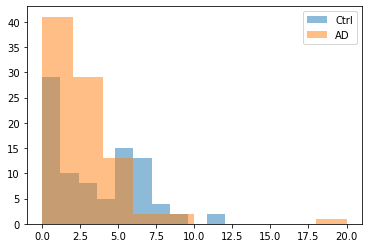

In [136]:
curKp = 2.83
_, n = ResCtrls[0].ndXmat.shape
ecptssCtrls = np.array([UpdateKp(curKp, detRessCtrls[ix].U0, n, ResCtrls[ix].ndXmat.shape[0], paras) for ix in range(len(detRessCtrls))])
_, n = ResADs[0].ndXmat.shape
ecptssADs = np.array([UpdateKp(curKp, detRessADs[ix].U0, n, ResADs[ix].ndXmat.shape[0], paras) for ix in range(len(detRessADs))])
print(np.mean(ecptssADs), np.mean(ecptssCtrls))
print(ttest_ind(ecptssADs, ecptssCtrls, equal_var=False))

plt.hist(ecptssCtrls, alpha=0.5, label="Ctrl")
plt.hist(ecptssADs, alpha=0.5, label="AD")
plt.legend()

## Run 

In [24]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

In [ ]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)

plt.figure(figsize=[10, 5])
plt.subplot(121)
for ix in range(68):
    plt.plot(Xmats_AD[0, ix, :])
plt.subplot(122)
for ix in range(68):
    plt.plot(Xmats_ctrl[0, ix, :])

### CP decomposition

In [ ]:
Amat_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_sum=True)

In [ ]:
Amat_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                            fct=paras.fct, nRks=paras.num_ranks, is_sum=True)

In [ ]:
# rank-R decomposition
tensors_ctrl = np.transpose(np.array(Amat_ctrls_lowrank), (1, 2, 0))
tensors_AD = np.transpose(np.array(Amat_ADs_lowrank), (1, 2, 0))

# the initial value 
Amat_ctrl_lowrank = np.sum(Amat_ctrls_lowrank, axis=0)
U, _, VT = np.linalg.svd(Amat_ctrl_lowrank)
ctrl_CPD_init = [U[:, :paras.r], VT.T[:, :paras.r]]

CPDresult_ctrl = sort_orthCPD(decompose_three_way_orth(tensors_ctrl, paras.r, init=ctrl_CPD_init))
CPDresult_AD = decompose_three_way_fix(tensors_AD, init=[CPDresult_ctrl[0], CPDresult_ctrl[1]])


In [41]:
names =["AD", "ctrl"]
CPDress = edict()
CPDress["AD"]= CPDresult_AD
CPDress["ctrl"]= CPDresult_ctrl

#### CPD factors

In [46]:
orgFn = lambda x: np.abs(x)
mmFn = lambda x: minmax_mat(np.abs(x), is_row)
cutFn = lambda x: minmax_mat(np.abs(x), is_row)>cutoff
def heat_plot(idx, curFn):
    plt.figure(figsize=[20, 10])
    for ix, nam in enumerate(names):
        plt.subplot(1, 2, ix+1)
        curRes = CPDress[nam]
        sns.heatmap(curFn(curRes[idx]))
        plt.title(nam)

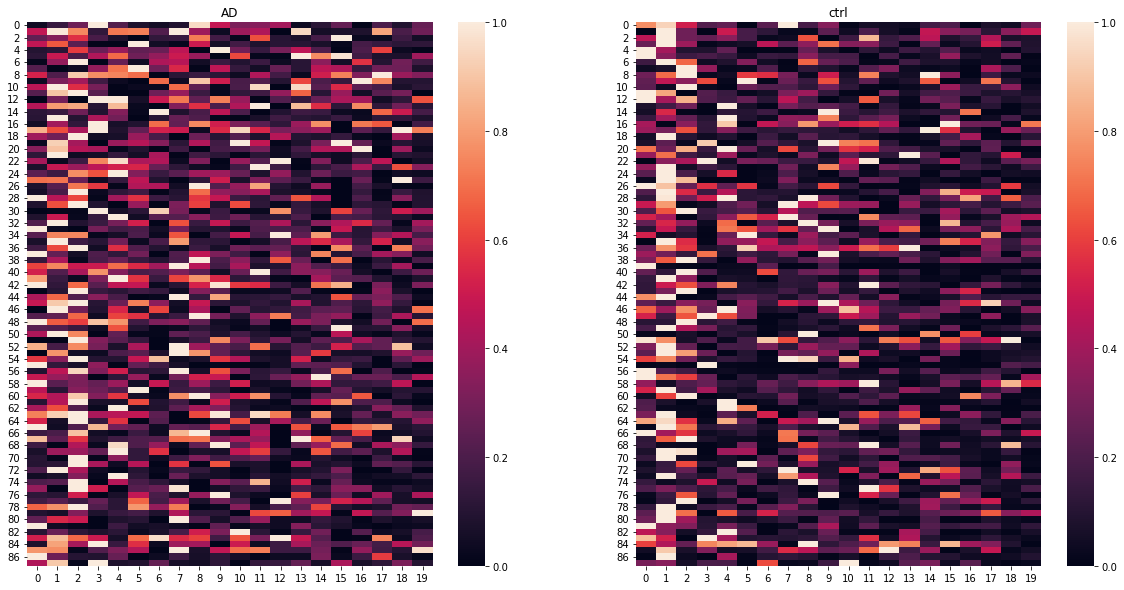

In [47]:
cutoff = 0.5
is_row = True
heat_plot(2, mmFn)
#heatPlotFn(2, mmFn)

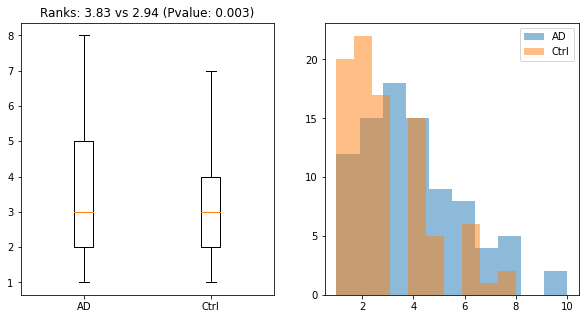

In [48]:
cutoff = 0.5
rksAD = cutFn(CPDress["AD"][-1]).sum(axis=1)
rksCtrl = cutFn(CPDress["ctrl"][-1]).sum(axis=1)
plt.figure(figsize=[10, 5])
plt.subplot(121)
_ = plt.boxplot([rksAD, rksCtrl], showfliers=False)
pval = ttest_ind(rksAD, rksCtrl, equal_var=False).pvalue
plt.xticks([1, 2], ["AD", "Ctrl"])
plt.title(f"Ranks: {np.mean(rksAD):.2f} vs {np.mean(rksCtrl):.2f} (Pvalue: {pval:.3f})")

plt.subplot(122)
plt.hist(rksAD, alpha=0.5, label="AD")
plt.hist(rksCtrl, alpha=0.5, label="Ctrl")
plt.legend()

#### corrs with 7 networks

In [49]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

defNetsFil = list(dataDir.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

mmDefNets = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    mmDefNets[curCol[0]] = minmax(np.array(curCol[1:]))
kysOrd = sorted(mmDefNets.keys())

In [50]:
idx = 0
corrMats = edict()
for ix, nam in enumerate(names):
    curRes = CPDress[nam]
    curUs = np.abs(curRes[idx])
    corrMat = np.zeros((7, curUs.shape[-1]))
    for iy in range(curUs.shape[-1]):
        curU = minmax(curUs[:, iy])
        for iz, kz in enumerate(kysOrd):
            curV = mmDefNets[kz]
            corrMat[iz, iy] = pearsonr(curU, curV)[0]
    corrMats[nam] = corrMat

In [51]:
def corr_plot():
    plt.figure(figsize=[15, 10])
    for ix, nam in enumerate(names):
        plt.subplot(2, 1, ix+1)
        curMat= corrMats[nam]
        sns.heatmap(curMat,  yticklabels=kysOrd, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=np.round(curMat, 2))
        plt.title(nam)

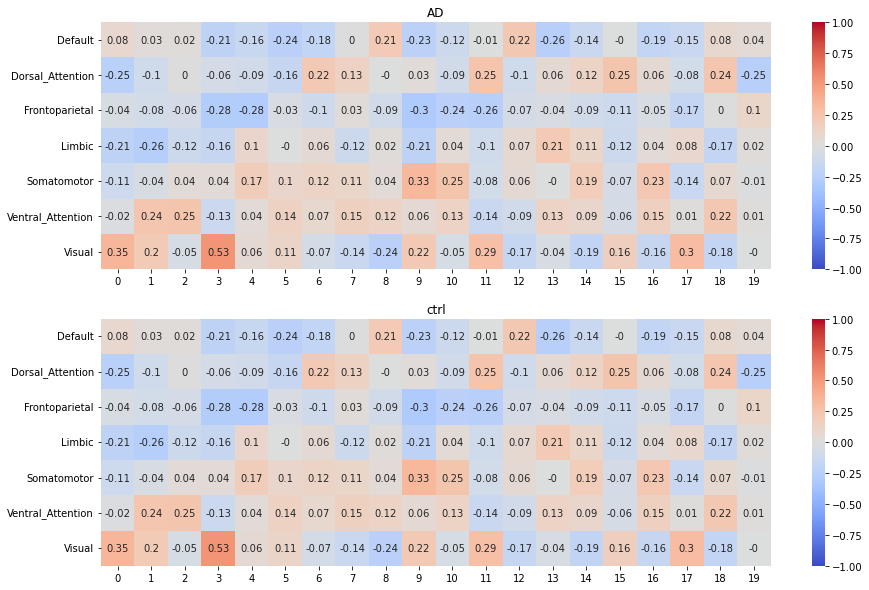

In [52]:
corr_plot()

### Reduce the dim of the data

In [35]:
B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]

In [63]:
ndXmats_ctrl =  np.matmul(B1.T[np.newaxis, :, :], dXmats_ctrl)
nXmats_ctrl =  np.matmul(B2.T[np.newaxis, :, :], Xmats_ctrl)
ndXmats_AD =  np.matmul(B1.T[np.newaxis, :, :], dXmats_AD)
nXmats_AD =  np.matmul(B2.T[np.newaxis, :, :], Xmats_AD)


### Screening

In [68]:
# Function to calculate the  Gamma_k matrix during dynamic programming for CP Decomposition
def get_gammak_4CPD(Ycur, Xcur):
    """
    Input: 
        Ycur: part of ndXmat, r x (j-i)
        Xcur: part of nXmat, r x (j-i)
    Return:
        Gamma matrix, r x r
    """
    r = Ycur.shape[0]
    GamMat = np.zeros((r, r))
    for ix in range(r):
        rY, rX = Ycur[ix, :], Xcur[ix, :]
        GamMat[ix, ix] = (rY.dot(rX))/(rX.dot(rX))
    return GamMat

In [71]:
def screening_4CPD(ndXmats, nXmats, wh=10, showProgress=True):
    """
    Input:
        wh: screening window size
    """
    # Get the scanning stats at index k
    def _get_scan_stats(k, wh):
        lidx = k - wh + 1
        uidx = k + wh + 1

        pndXmatA = ndXmat[:, lidx:uidx]
        pnXmatA = nXmat[:, lidx:uidx]
        GamkA = get_gammak_4CPD(pndXmatA, pnXmatA)
        nlogA = get_Nlogk(pndXmatA, pnXmatA, GamkA)

        pndXmatL = ndXmat[:, lidx:(k+1)]
        pnXmatL = nXmat[:, lidx:(k+1)]
        GamkL = get_gammak_4CPD(pndXmatL, pnXmatL)
        nlogL = get_Nlogk(pndXmatL, pnXmatL, GamkL)

        pndXmatR = ndXmat[:, (k+1):uidx]
        pnXmatR = nXmat[:, (k+1):uidx]
        GamkR = get_gammak_4CPD(pndXmatR, pnXmatR)
        nlogR = get_Nlogk(pndXmatR, pnXmatR, GamkR)

        return nlogR + nlogL - nlogA

    N, rAct, n = ndXmats.shape
    canptss = []
    if showProgress:
        iterBar = trange(N, desc="Screening")
    else:
        iterBar = range(N)
    for ix in iterBar:
        ndXmat, nXmat = ndXmats[ix, :, :], nXmats[ix, :, :]
        scanStats = []
        for iy in range(n):
            if iy < (wh-1):
                scanStats.append(np.inf)
            elif iy >= (n-wh):
                scanStats.append(np.inf)
            else:
                scanStats.append(_get_scan_stats(iy, wh))

        canpts = []
        for idx, scanStat in enumerate(scanStats):
            if (idx >= (wh-1)) and (idx < (n-wh)):
                lidx = idx - wh + 1
                uidx = idx + wh + 1
                if scanStat == np.min(scanStats[lidx:uidx]):
                    canpts.append(idx) # the change point is from 0 not 1

        canptss.append(canpts)
    return canptss

In [76]:
candidate_pts_ctrls = screening_4CPD(ndXmats_ctrl, nXmats_ctrl, wh=paras.wh)
candidate_pts_ADs = screening_4CPD(ndXmats_AD, nXmats_AD, wh=paras.wh)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [10:38<00:00,  7.26s/it]


### Detection

In [80]:
# Effcient dynamic programming to optimize the MBIC, 
def dyna_prog_4CPD(ndXmat, nXmat, kappa, Lmin=None, canpts=None, maxM=None, is_full=False, Ms=None, showProgress=True):
    """
    Input:
    ndXmat: array, r x n. n is length of sequence. 
    nXmat: array, r x n. n is length of sequence. 
    kappa: The parameter of penalty
    Lmin: The minimal length between 2 change points
    canpts: candidate point set. list or array,  index should be from 1
    maxM: int, maximal number of change point 
    Ms: the list containing prespecified number of change points.
       When Ms=None, it means using MBIC to determine the number of change points
    is_full: Where return full outputs or not
    Return:
        change point set with index starting from 1
        chgMat: A matrix containing the change points for each number of change point
        U0: MBIC without penalty
        U:  MBIC  for each number of change point
    """
    def _nloglk(i, j):
        length = j - i + 1
        pndXmat = ndXmat[:, i:(j+1)]
        pnXmat = nXmat[:, i:(j+1)]
        Gamk = get_gammak_4CPD(pndXmat, pnXmat)
        if length >= Lmin:
            return get_Nlogk(pndXmat, pnXmat, Gamk)
        else:
            return decon 

    r, n = nXmat.shape
    if Lmin is None:
        Lmin = r
        
    decon = np.inf

    if Ms is not None:
        Ms = sorted(Ms)
    if canpts is None:
        canpts = np.arange(n-1)
    else:
        canpts = np.array(canpts)
    M0 = len(canpts) # number of change point in candidate point set

    if (maxM is None) or (maxM>M0):
        maxM = M0 
    if not (Ms is None or len(Ms)==0):
        maxM = Ms[-1] if Ms[-1]>=maxM else maxM
    canpts_full = np.concatenate(([-1], canpts, [n-1]))
    canpts_full2 = canpts_full[1:]
    canpts_full1 = canpts_full[:-1] + 1 # small

    Hmat = np.zeros((M0+1, M0+1)) + decon

    # create a matrix 
    if showProgress:
        proBar = trange(M0+1, desc="Dynamic Programming")
    else:
        proBar = range(M0+1)
    for ix in proBar:
        for jx in range(ix, M0+1):
            iidx, jjdx = canpts_full1[ix],  canpts_full2[jx]
            Hmat[ix, jx]  = _nloglk(iidx, jjdx)

    # vector contains results for each number of change point
    U = np.zeros(maxM+1) 
    U[0] = Hmat[0, -1]
    D = Hmat[:, -1]
    # contain the location of candidate points  (in python idx)
    Pos = np.zeros((M0+1, maxM)) + decon
    Pos[M0, :] = np.ones(maxM) * M0
    tau_mat = np.zeros((maxM, maxM)) + decon
    for k in range(maxM):
        for j in range(M0): # n = M0 + 1
            dist = Hmat[j, j:-1] + D[(j+1):]
            #print(dist)
            D[j] = np.min(dist)
            Pos[j, 0] = np.argmin(dist) + j + 1
            if k > 0:
                Pos[j, 1:(k+1)] = Pos[int(Pos[j, 0]), 0:k]
        U[k+1] = D[0]
        tau_mat[k, 0:(k+1)] = Pos[0, 0:(k+1)] - 1
    U0 = U 
    U = U + 2*r*np.log(n)**kappa* (np.arange(1, maxM+2))
    chgMat = np.zeros(tau_mat.shape) + np.inf
    for iii in range(chgMat.shape[0]):
        idx = tau_mat[iii,: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        chgMat[iii, :(iii+1)]= np.array(canpts)[idx] + 1 
    
    mbic_numchg = np.argmin(U[:(maxM+1)])
    if mbic_numchg == 0:
        mbic_ecpts = np.array([])
    else:
        idx = tau_mat[int(mbic_numchg-1),: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        mbic_ecpts = np.array(canpts)[idx] + 1
        
    if Ms is None or len(Ms)==0:
        if not is_full:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})
    else:
        ecptss = []
        for numchg in Ms:
            if numchg == 0:
                ecpts = np.array([])
            else:
                idx = tau_mat[int(numchg-1),: ]
                idx = np.array(idx[idx<np.inf], dtype=int)
                ecpts = np.array(canpts)[idx] + 1
            ecptss.append(ecpts)
        if not is_full:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})

In [83]:
cpts_ctrls = []
for ix in trange(len(candidate_pts_ctrls)):
    res = dyna_prog_4CPD(ndXmats_ctrl[ix], nXmats_ctrl[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ctrls[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ctrls.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [30:28<00:00, 20.78s/it]


In [84]:
cpts_ADs = []
for ix in trange(len(candidate_pts_ADs)):
    res = dyna_prog_4CPD(ndXmats_AD[ix], nXmats_AD[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ADs[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ADs.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [31:58<00:00, 21.81s/it]


### Save the results

In [826]:
results = edict()
results.paras = paras

results.AD = edict()
results.AD.cpts = cpts_ADs
results.AD.candidate_pts = candidate_pts_ADs
results.AD.ndXmats = ndXmats_AD
results.AD.nXmats = nXmats_AD
results.AD.CPDres = CPDresult_AD

results.ctrl = edict()
results.ctrl.cpts = cpts_ctrls
results.ctrl.candidate_pts = candidate_pts_ctrls
results.ctrl.ndXmats = ndXmats_ctrl
results.ctrl.nXmats = nXmats_ctrl
results.ctrl.CPDres = CPDresult_ctrl
save_pkl(paras.res_dir/"CPD_results_detect_first.pkl", results)

In [6]:
results = load_pkl(paras.res_dir/"CPD_results_detect_first.pkl")

Load file ../results/CPD_results_detect_first.pkl
